##### import packages

In [56]:
#!pip install fredapi
#!pip install tqdm
#!pip install python-bea
#!pip install yahoo_fin

from fredapi import Fred
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import time
from tqdm.notebook import tqdm
from statsmodels.tsa.stattools import adfuller
from scipy.linalg import orth
from pprint import pprint
from pybea.client import BureauEconomicAnalysisClient
from datetime import date
from IPython.display import HTML
from yahoo_fin.stock_info import get_data
from scipy.optimize import minimize
import pull_all_data                        # python script to pull the data from FRED and BEA 
import dfm_helper_functions                 # python script with useful functions for illustrations
import models                               # python script for different models used 

# Final Project

Augustin Belin 

May 2024

## Outline 

The project is organized as follows:
- (1) Introduction
- (2) Data
- (3) DFM With Same Frequency Data
  - (3.1) Principal Component Analysis (PCA)
  - (3.1) VAR Specification
- (4) DFM With Mixed Frequency Data
  - (4.1) The Expectation Maxiximization Algorithem
  - (4.2) A State Space Representation of a DFM (With Dynamic Factors) 
- (5) Discussion
- (6) References

## (1) Introduction

Dynamic factor models (DFMs) suggest that few latent factors explain a much larger number of observed time series (Stock and Watson, 2016). These models provide estimates of the dynamics and hidden factors themselves. Applications of DFMs include: 
- Nowcasting: This technique involves leveraging more frequent series to create a current forecast of series that come out less often. An example is the 
  NY FED’s nowcast model which uses monthly series to forecast GDP at a monthly frequency.
- Macroeconomic monitoring and Creating indicators: The underlying factors estimated can provide valuable information about the state of the economy. 
  See the Global Supply Chain Pressure Index for a great example of this.
- Forecasting: Given we specify how the dynamics of how the factors evolve they can prove to be valuable tools in economic forecasting.

This project focuses on the third bullet. Using data from multiple sources and frequencies, I explore different estimation methods and specifications of DFMs. 

## (2) Data
These models will be used in an effort to forecast inflation of the three main sectors of personal consumption expenditures (PCE) -- goods, services, and housing. These series are taken from the BEA website through the API they offer and cleaned in the **pull_all_data.py** file. We take the 14 sectors in core PCE and weight the growth rate of the indices  by the expenditure shares of each sector for aggregation. 

The rest of the data is pulled from other sources to create the 4 main factors used in forecasting inflation. Most of the series in each factor will fall into one of the categories outlined below: 

| Supply | Demand | Housing | Financial |
| --- | --- | ---|  --- |
-labor supply           | -monetary policy | -housing starts         | -stock market |  
-energy shocks          | -fiscal policy   | -mortgages              |-credit supply pressures |  
-supply chain pressures |                  | -mortgage delinquencies | |  

Each series is deemed stationary by the augmented Dickey–Fuller test after the correct transformations have been made (often simply the percent change between $t$ and $t-1$).

### load data

In [57]:
start_date       = "1999-01-01"
#url_factors     = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vS5gzUKaQAkqmBcaLa83tyyWQBKMhAx7cqbO6oeUrsID7VnLJ6_gtMG84jB7QgJt2--m__-huA6Pmxr/pub?output=csv'
url_factors      = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vStInu1k_beRqIuEVQZB8QYs2rDlYVKBbulnOcbKQ8qyesWcsRqeDhMswTl92tdLTNnGjjL6icyTh6N/pub?output=csv'
data_id_codes    = pd.read_csv(url_factors)
tickers          =  ["^IXIC", "^GSPC"]

# pull from APIs
factor_dict                                       = pull_all_data._Pull_Fred_Data(data_id_codes, start_date, verbose=False, quarterly=1, monthly=1, weekly=1, daily=1)
agg_sectors_inf, agg_pce_inf, agg_shares, agg_exp = pull_all_data._Pull_BEA_Data()
GSCPI                                             = pull_all_data._Pull_GSCPI_Data(start_date)
index_df                                          = pull_all_data._Pull_Yahoo_Data(tickers, start_date)

# append GSCPI and indexes to the respective factors
factor_dict["supply"]    = pd.concat([factor_dict["supply"], GSCPI], axis = 1)
factor_dict["financial"] = pd.concat([factor_dict["financial"], index_df], axis = 1)

# create EE/UE flows
EE_UE                          = factor_dict["supply"]["Labor Force Flows Employed to Employed"]/factor_dict["supply"]["Labor Force Flows Unemployed to Employed"] 
factor_dict["supply"]["EE/UE"] = EE_UE
factor_dict["supply"]          = factor_dict["supply"].drop(columns=["Labor Force Flows Employed to Employed", "Labor Force Flows Unemployed to Employed"])      # drop EE and UE flows

# append codes to the table
data_id_codes_table                               = data_id_codes
data_id_codes_table.loc[len(data_id_codes_table)] =  ["temp", tickers[0], "financial", "percent change", "monthly" ]
data_id_codes_table.loc[len(data_id_codes_table)] =  ["temp", tickers[1], "financial", "percent change", "monthly" ]
data_id_codes_table.loc[len(data_id_codes_table)] =  ["temp", "GSCPI", "supply", "index", "monthly" ]
data_id_codes_table.loc[len(data_id_codes_table)] =  ["temp", "EE/UE", "supply", "percent change", "monthly" ]
data_id_codes_table                               = data_id_codes_table[data_id_codes_table["id"] != "LNS17000000"]      
data_id_codes_table                               = data_id_codes_table[data_id_codes_table["id"] != "LNS17100000"]    # drop EE and UE flows

# take note of series that are not quarterly
monthly_series      = data_id_codes_table.loc[data_id_codes_table['frequency'] != 'quarterly']
factor_dict_monthly = factor_dict.copy()

# get monthly factor_dict
for factor in factor_dict:
    for serie in list(factor_dict[factor].columns):
        if serie in monthly_series["desc"].values:
            continue 
        else:
            factor_dict_monthly[factor] = factor_dict_monthly[factor].drop(columns=[serie])

https://apps.bea.gov/api/data/?UserID=E8646E50-F4E4-458F-9194-2CC374585B65&method=GETDATASETLIST&ResultFormat=JSON
https://apps.bea.gov/api/data/?userid=E8646E50-F4E4-458F-9194-2CC374585B65&method=GETPARAMETERLIST&datasetname=NIPA&resultformat=JSON
https://apps.bea.gov/api/data/?userid=E8646E50-F4E4-458F-9194-2CC374585B65&method=GetData&datasetname=NIUnderlyingDetail&year=1970%2C1971%2C1972%2C1973%2C1974%2C1975%2C1976%2C1977%2C1978%2C1979%2C1980%2C1981%2C1982%2C1983%2C1984%2C1985%2C1986%2C1987%2C1988%2C1989%2C1990%2C1991%2C1992%2C1993%2C1994%2C1995%2C1996%2C1997%2C1998%2C1999%2C2000%2C2001%2C2002%2C2003%2C2004%2C2005%2C2006%2C2007%2C2008%2C2009%2C2010%2C2011%2C2012%2C2013%2C2014%2C2015%2C2016%2C2017%2C2018%2C2019%2C2020%2C2021%2C2022%2C2023%2C2024&resultformat=JSON&frequency=M&tablename=T20805
https://apps.bea.gov/api/data/?userid=E8646E50-F4E4-458F-9194-2CC374585B65&method=GetData&datasetname=NIUnderlyingDetail&year=1970%2C1971%2C1972%2C1973%2C1974%2C1975%2C1976%2C1977%2C1978%2C1979%2

Below is a summary table the series used for each factor and their frequency. Frequencies are important as some models will only be able to handle same frequency data. Daily/weekly series are transformed to monthly by averaging the observed values over a given month. 

In [58]:
factor_table = pull_all_data._Get_Factor_Table(data_id_codes_table)

,series,frequency,housing,demand,supply,financial
0,Industrial Production: Total Index,monthly,,,X,
1,Industrial Production: Final Products and Nonindustrial Supplies,monthly,,,X,
2,Industrial Production: Final Products,monthly,,,X,
3,Industrial Production: Consumer Goods,monthly,,,X,
4,Industrial Production: Durable Consumer Goods,monthly,,,X,
5,Industrial Production: Non-Durable Consumer Goods,monthly,,,X,
6,Industrial Production: Equipment: Business Equipment,monthly,,,X,
7,Industrial Production: Materials,monthly,,,X,
8,Industrial Production: Durable Goods Materials,monthly,,,X,
9,Industrial Production: Non-Durable Goods Materials,monthly,,,X,


## (3) DFM With **Same** Frequency Data

under this situation the DFM can be simply estimated in a 2 step process: 
- run PCA to get the factors and loadings&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;(1)
- run a VAR, estimating the parameters through OLS &nbsp;&nbsp;&nbsp;&nbsp;(2)

### (3.1) Principal Components Analysis (PCA)

PCA is one of the most ingrained methods of dimensionality reduction. The technique consists  of taking many series and condensing them into few **factors** that capture most of the variation in the data. PCA can be leveraged for forecasting time series, ensuring that we maintain the information of sometimes dozens of features while providing the tractability of a model with fewer parameters to estimate.

#### Steps for getting PCA factors:
First we must standardize the data to be $\mu = 0$ and  $\sigma^2 = 1$. Let there be N features, each with T observations:

\begin{align}
  X &=
      \begin{bmatrix}
       (x_{0}^T - \mu_{0})/\sigma_{0}^2 \\           
       \vdots \\
       (x_{n}^T - \mu_{n})/\sigma_{n}^2
      \end{bmatrix}
\end{align}

since the data is standardized the sample covariance matrix is simply written as:

\begin{align}
  \Sigma &= \frac{1}{N}X^TX
\end{align}

Let $\alpha$ be a $N\times1$ vector with unit length (i.e. $\alpha'\alpha = 1$). Our goal is to find the $\alpha'X$ that maximizes: 

\begin{align}
  Var(\alpha'X) &= \alpha'\Sigma\alpha \\
\end{align}

To maximize the above variance subject to $\alpha$ having unit length we use the technique of Lagrange multipliers. The function to maximize:

\begin{align}
  \alpha' \Sigma \alpha - \lambda(\alpha'\alpha -1) \\
\end{align}

w.r.t. to $\alpha$. 

\begin{align}
  \frac{d}{d\alpha}(\alpha' \Sigma \alpha - \lambda(\alpha'\alpha -1)) = 0 \\
  \vdots \\
  \Sigma \alpha = \lambda\alpha
\end{align}

We can recognize this as the eigenvector  equation where $\alpha$ is an eigenvector of $\Sigma$ and $\lambda$ is the corresponding eigenvalue. To maximize the above relationship simply choose the eigenvector associated with the largest eigenvalue. Note, this method works as we are only creating 1 principal component, if we wanted multiple more constraints would have to be placed. Then, treating $\alpha$ as loadings we can get the factor values by simply multiplying the loadings and the historical data of the series. An example of the relation between the factor and data below:

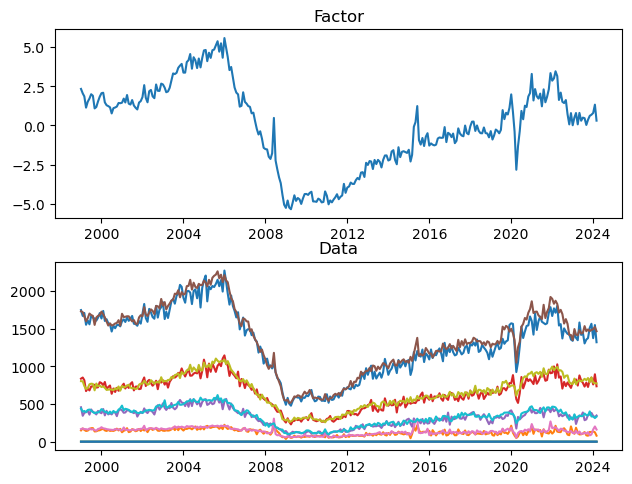

In [59]:
factor_of_interest = factor_dict_monthly["housing"]
df_factor_values, df_loadings = dfm_helper_functions.get_factor_pca(factor_of_interest)

fig, ax = plt.subplots(2, 1)
fig.tight_layout()

ax[0].plot(df_factor_values.index, df_factor_values.values) #row=0, col=0
ax[0].set_title("Factor")
ax[1].plot(factor_of_interest.index, factor_of_interest.values) #row=1, col=0
ax[1].set_title("Data")

plt.show()

### (3.2) VAR Specification and Estimation

The model is a VAR with the 3 $y_{i}$'s represented as the 3 main sectors of core PCE inflation (goods, services, and housing). Suppose we specify $l$ lags for each $y_{i}$ and $n$ factors, then the VAR has the form below.  

\begin{align}
  \begin{bmatrix}
   y_{1,t}\\
   y_{2,t}\\
   y_{3,t}\\
  \end{bmatrix}
  =
  \begin{bmatrix}
   \beta_{1,1} & ... & \beta_{1,l} & \beta_{2,1} & ... & \beta_{2,l} & \beta_{3,1} & ... & \beta_{3,l} \\
   \beta_{1,1} & ... & \beta_{1,l} & \beta_{2,1} & ... & \beta_{2,l} & \beta_{3,1} & ... & \beta_{3,l} \\
   \beta_{1,1} & ... & \beta_{1,l} & \beta_{2,1} & ... & \beta_{2,l} & \beta_{3,1} & ... & \beta_{3,l} \\
  \end{bmatrix}
  \begin{bmatrix}
   y_{1,t-1} \\
   \vdots \\
   y_{1,t-l} \\
   y_{2,t-1} \\
   \vdots \\
   y_{2,t-l} \\
   y_{3,t-1} \\
   \vdots \\
   y_{3,t-l} \\
  \end{bmatrix}
  +
  \begin{bmatrix}
   \psi{1,1} & ... & \psi{1,n} \\
   \psi{2,1} & ... & \psi{2,n} \\
   \psi{3,1} & ... & \psi{3,n} \\
  \end{bmatrix}
  \begin{bmatrix}
   f_{1,t} \\
   \vdots \\
   f_{n,t} \\
  \end{bmatrix}
  +
  \begin{bmatrix}
   \epsilon_{1,t} \\
   \epsilon_{2,t} \\
   \epsilon_{3,t} \\
  \end{bmatrix}
\end{align}


with factors following the dynamics given by:


\begin{align}
  \begin{bmatrix}
   f_{1,t} \\
   \vdots \\
   f_{n,t} \\
  \end{bmatrix}
  =
  \begin{bmatrix}
   \rho_{1} &    0    & ...         & 0 \\
   0       & \rho_{2} & 0           & \vdots \\
   \vdots  &   0     & \ddots      & 0 \\
   0       & ...     & 0           & \rho_{n} \\
  \end{bmatrix}
  \begin{bmatrix}
   f_{1,t-1} \\
   \vdots \\
   f_{n,t-1} \\
  \end{bmatrix}
  +
  \begin{bmatrix}
   \omega_{1,t} \\
   \vdots \\
   \omega_{n,t} \\
  \end{bmatrix}
\end{align}

Putting the two steps together we can get parameter estimates for the coefficients on the lags of the main core PCE sectors and factors. Iterating forward we can get forecasts.

<Axes: title={'center': 'DFM PCA - 2 year forecast'}>

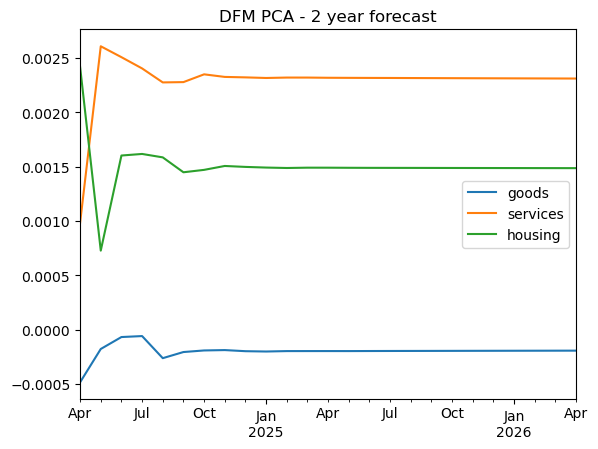

In [60]:
#pca_factor_dict = {"labor": labor, "supply": supply, "housing": housing}
Y_lags = 3

dfm_pca = models.DFM_PCA(agg_sectors_inf, factor_dict_monthly, Y_lags)
dfm_pca_params  = dfm_pca._Get_Estimates()
dfm_pca._Create_Forecast().plot(title="DFM PCA - 2 year forecast")

The above forecasts are generated from the factors below:

<Axes: title={'center': 'Factors estimated through PCA over pre-covid period'}>

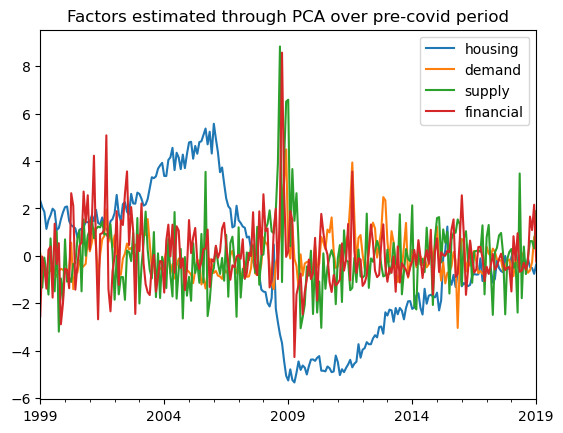

In [61]:
# plot factors over the time period
dfm_pca.df_exog.loc[:"01-01-2019"].plot(title="Factors estimated through PCA over pre-covid period")

## (4) DFM With **Mixed** Frequency Data

under this situation the DFM can be estimated through two methods: 
- the expectation maximization algorithm (EM) &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;(1)
- a state space model estimated through the Kalman Filter &nbsp;&nbsp;&nbsp;&nbsp;(2)

## (4.1) The Expectation Maximization Algorithm
under this situation the DFM can be simply estimated in a 2 step process: 
- run PPCA to get the factors and loadings
- run a VAR, estimating the parameters through OLS

### PPCA derivations

Let $y$ denote the data matrix of size $n \times D$ and $x$ denote the vector of principal component coordinates of size $n \times d$. Each of which belong to theirespective ve dimensions:

\begin{align}
  y \in \mathbb{R}^D \\
  x \in \mathbb{R}^d \\
\end{align}

It is assumed that $D \ge d$, meaning there are fewer factors that describe the data than series themselves. Let us assume the priors,

\begin{align}
  p(x)   &= \mathcal{N}(x;0,I) \\
  p(y|x) &= \mathcal{N}(y;C^Tx, \sigma^2 I) \\
\end{align}

We let $C$ be a $d \times D$ matrix. Intuitively, $C$ acts as a bridge between the principal components coordinates and the feature coordinates. This is eecially usefully when dealing with missing data and provides us a way to estimate the factors and missing entries of $y$ simultaneously. We have a way to get from the nrincipal coordimate space to the data coordinates, we now need a method to return. The conditional $x|y$ is,

\begin{align}
  p(x) &= \mathcal{N}(x;\mu,\Sigma) \\
  \mu  &= \sigma^{-2} \Sigma C y \tag{1} \\
  \Sigma^{-1}  &= I + \sigma^{-2}CC^T\tag{2}\\
\end{align}

### E-step: estimate the missing values
From above we can find the optimal distributions of $y_{missing}$ and $x$ at each step given by:

\begin{align}
  q(y_{missing}) &= \mathcal{N}(y_{missing};C_{missing}^T\bar{x},\sigma^2I) \\
  q(x)           &= \mathcal{N}(x;\sigma^{-2}\Sigma C \bar{y}, \Sigma) \\
\end{align}

In practice, we first project the estimate of $x$ onto the data coordinates to get our best estimate of $y_{missing}$. We then update $\Sigma$ according to (2) and get a new estimate of the factor $x$m from (1).

### M-step: given data, maximize the Foi ant log-likelihoexplanation $y$
for more in depth explaination of the derivation of the data likelihood please look at the SOURCE BELOW. Maximizing this likelihood over $C$ and $\sigma$ we get the updating rules:

\begin{align}
  C        &= (N\Sigma + \bar{X}\bar{X}^T)^{-1} \bar{X}\bar{Y}^T \\
  \sigma   &= \frac{1}{ND}(NTr({C^T \Sigma C}) + \sum_n{||\bar{y_n} - C^T\bar{x_n}||} + D_h\sigma_{old}^2) \\
\end{align}

$D_h$ represents the number of missing values in $y$, $\sigma_{old}$ is the $\sigma$ from the previous iteration, and $\bar{X}$&$\bar{Y}$ store values of $\bar{x}$&$\bar{y}$ respectively.

### Objective Function:
After performingwhether-step we are left with the question of wether to iterate further. This can be decided by setting a threshold on the difference between the log-likelihood of two iterations. The log-likelihood is given below:

\begin{align}
  logp(y_o)   &= \frac{ND}{2}(1+log \sigma^2) + \frac{N}{2}(Tr(\Sigma) - log|\Sigma|) - \frac{1}{2} \sum_n{||x_n||^2 + \frac{D_h}explanations {old}^2} \\
\end{align}

Again for explainations on derivations refer to SOURCE X and SOURCE Y . If the differences relativelyve objepre-specified on has converged to a relativley small prespecifed value we return $y$ (now complete with missing values) and $x$. Otherwise we start from the e-step again and continue.

### A Brief Illustration of PPCA in Action

The below exercise shows the evolution of the bridge matrix $C$ and the interpolated data as the algorithm converges. Services in core PCE are transformed to quarterly observations by omitting every 2 months. The "true" omitted values are given by the gray  dots in the "Realized Monthly Data" chart. The EM algorithm is then run with this missing data and will provide us with $C$ -- which is used in the calculation of the factors -- and gives us a best estimate of the monthly values of the missing data (the gray  dots in the iteration charts). The EM algorithm provides sensible estimates of the missing data for "free" during the convergence process which can be extremely useful in nowcasting.  

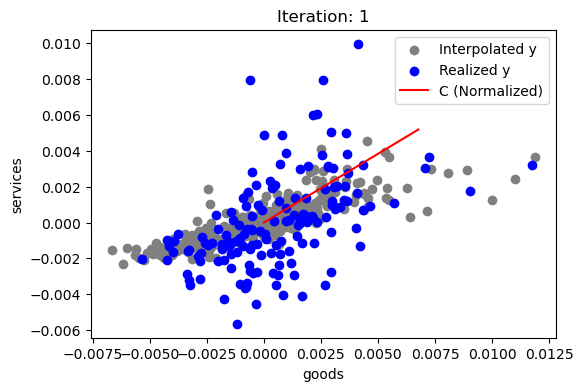

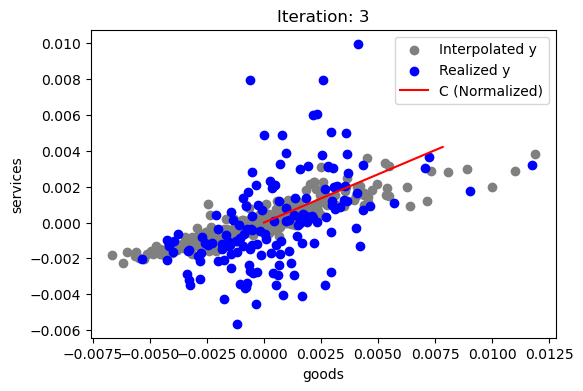

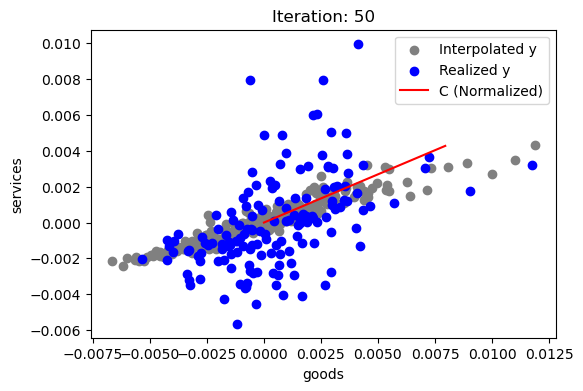

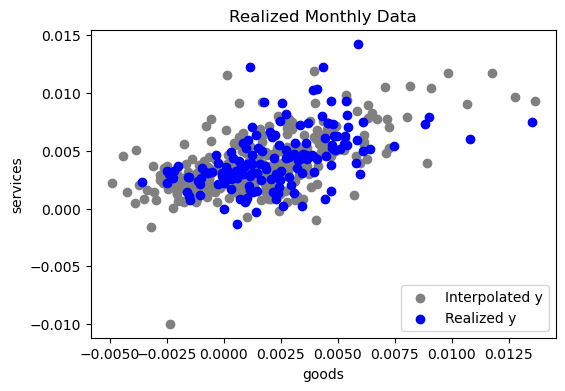

In [62]:
# remove data from one of the series to convert it to quarterly data
# then plot first n_repeat*3 months
n_repeat  = 150
i_missing = dfm_helper_functions.repeat([1, np.nan, np.nan], n_repeat).flatten()
PPCA_data = agg_sectors_inf.iloc[:n_repeat*3,0:3]                                               # set counter_factual data to have all realized points
PPCA_data['services'] = PPCA_data['services'] * i_missing
X, Ye = dfm_helper_functions._Get_Factor_PPCA(PPCA_data,  plot=True)

# plot the counterfactual scatter as well... this is only the monthly data
counter_factual = agg_sectors_inf.iloc[:n_repeat*3,0:3]
# change labels and add legends
plt.figure(figsize=(6,4))
plt.xlabel(counter_factual.columns[0])
plt.ylabel(counter_factual.columns[1])
plt.title("Realized Monthly Data")
# plot missing values
scatter_interp   = plt.scatter(counter_factual.iloc[np.isnan(i_missing),0], counter_factual.iloc[np.isnan(i_missing),1], color="grey")
# plot realized values
scatter_realized = plt.scatter(counter_factual.iloc[np.invert(np.isnan(i_missing)),0], counter_factual.iloc[np.invert(np.isnan(i_missing)),1], color="blue")
plt.legend([scatter_interp, scatter_realized], ['Interpolated y', 'Realized y'])
plt.show()

### Putting it Together:

Once we have gotten the estimates of the factors through the EM algorithm  we can simply run the same VAR specification as the same frequency DFM.

<Axes: title={'center': 'DFM PPCA - 2 year forecast'}>

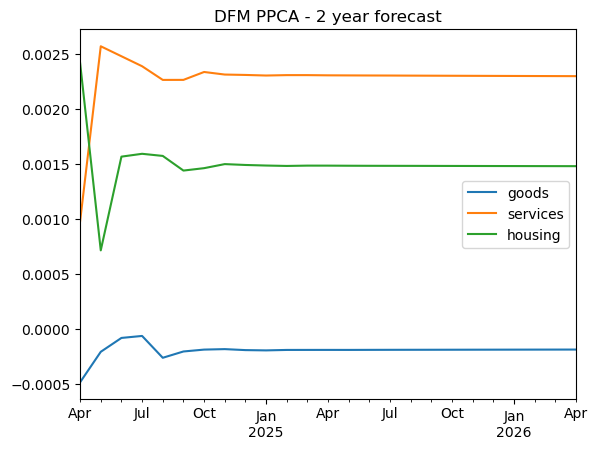

In [63]:
#ppca_factor_dict = {"labor": labor, "supply": supply, "housing": housing, "financial":financial}
Y_lags = 3

dfm_ppca = models.DFM_PPCA(agg_sectors_inf, factor_dict, Y_lags)
dfm_ppca_params  = dfm_ppca._Get_Estimates()
dfm_ppca._Create_Forecast().plot(title="DFM PPCA - 2 year forecast")

The above estimates created from the factors below: 

<Axes: title={'center': 'Factors estimated through PPCA over pre-covid period'}>

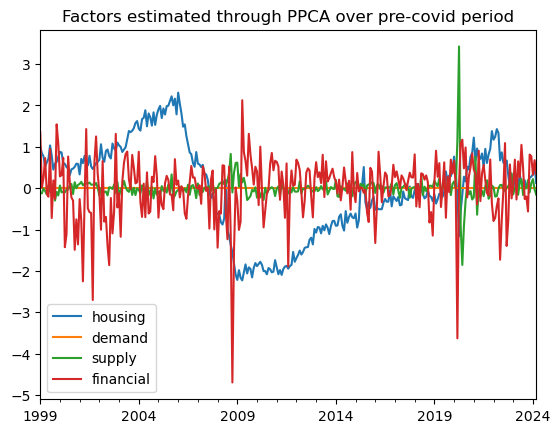

In [64]:
dfm_ppca.df_exog.plot(title="Factors estimated through PPCA over pre-covid period")

## (4.2) A State Space Representation of a DFM (With Dynamic Factors)

State space models (SSM) can be useful in estimating DFMs. SSMs focus on a set of m unobserved state variables $x_t$ that are related to N-dimensional feature space $y_t$.

\begin{align}
  \underset{N\times 1}{y_t}   &= \underset{N\times m}{Z} \times \underset{m\times 1}{x_t} + \underset{N\times N}{D} \times \underset{N\times 1}{\epsilon_t} \\
  \underset{m\times 1}{x_t}   &= \underset{m\times m}{W} \times \underset{m\times 1}{x_{t-1}} + \underset{m\times m}{R} \times \underset{m\times 1}{\eta_t} \\
\end{align}

And,

\begin{align}
  H : N \times N \tag{H is the covariance matrix of $\epsilon$}   \\
  Q : m \times m \tag{Q is the covariance matrix of $\eta$}      \\
\end{align}

In fact both the DFM-PCA and DFM-PPCA are implicitly in simple SSM form. If we pick the correct $Z$ and $W$ we can have each factor evolve according to an idiosyncratic (lag of itself) and trend component (global) factor. Let $f_i$ be the i'th factor created with $n_i$ observed series. We stack observed series so that the first $n_1$ series in our $y_t$ vector are the series belonging to the first factor. Continue this until we have added all the observed series.

 \begin{align}
  \begin{bmatrix}
   y_{\in{f_1}1,t}\\
   \vdots         \\
   y_{\in{f_1}n_1,t}\\
   y_{\in{f_2}1,t}\\
   \vdots         \\
   y_{\in{f_2}n_2,t}\\
   \vdots         \\
   y_{\in{f_m}1,t}\\
   \vdots         \\
   y_{\in{f_m}n_m,t}\\
  \end{bmatrix}
  =
  \begin{bmatrix}
    \beta_{\in{f_1},1} & 0 & ... & 0 & \beta_{\in{f_1}, global, 1} \\
    \vdots             & 0 & ... & 0 & \vdots\\
    \beta_{\in{f_1},n_1} & 0 & ... & 0 & \beta_{\in{f_1}, global, n_1}\\
    0 & \beta_{\in{f_2},1} & ... & 0 & \beta_{\in{f_2}, global, 1}\\
    0                      & \vdots & ... & 0 & \vdots\\
    0 & \beta_{\in{f_2},1} & ... & 0 & \beta_{\in{f_2}, global, n_2}\\
    \vdots            & \vdots & ... & \vdots & \vdots\\
    0 & 0 & ... & \beta_{\in{f_m},1} & \beta_{\in{f_m}, global, 1}\\
    0           & 0 & ... & \vdots & \vdots\\
    0 & 0 & ... & \beta_{\in{f_m},1} & \beta_{\in{f_m}, global, 1}\\
  \end{bmatrix}
  \begin{bmatrix}
   f_{1,t} \\
   f_{2,t} \\
   \vdots \\
   f_{m,t} \\
   f_{global,t} \\
  \end{bmatrix}
  +
  \begin{bmatrix}
   \epsilon_{\in{f_1}1,t}\\
   \vdots         \\
   \epsilon_{\in{f_1}n_1,t}\\
   \epsilon_{\in{f_2}1,t}\\
   \vdots         \\
   \epsilon_{\in{f_2}n_2,t}\\
   \vdots         \\
   \epsilon_{\in{f_m}1,t}\\
   \vdots         \\
   \epsilon_{\in{f_m}n_m,t}\\
  \end{bmatrix}
\end{align}

with the factors being explained through the dynamics below:

 \begin{align}
  \begin{bmatrix}
   f_{1,t}\\
   f_{2,t}\\
   \vdots         \\
   f_{m,t}\\
   f_{global,t}\\
  \end{bmatrix}
  =
  \begin{bmatrix}
    \rho_{1} & 0 & ... & 0 & \rho_{global, 1}\\
    0 & \rho_{2} & ... & 0 & \rho_{global, 2}\\
    \vdots             & 0 & \ddots & 0 & \vdots\\
    0 & 0 & 0 & \rho_{m} & \rho_{global, m}\\
    0 & 0 & ... & 0 & \rho_{global, global}\\
  \end{bmatrix}
  \begin{bmatrix}
   f_{1,t-1} \\
   f_{2,t-1} \\
   \vdots \\
   f_{m,t-1} \\
   f_{global,t-1} \\
  \end{bmatrix}
  +
  \begin{bmatrix}
    \phi_{1} & 0 & 0 & 0 & 0 \\
    0 & \phi_{2} & 0 & 0 & 0\\
    0 & 0 & \ddots & 0 & 0\\
    0 & 0 & 0 & \phi_{m} & 0\\
    0 & 0 & 0 & 0 & \phi_{global}\\
  \end{bmatrix}
  \begin{bmatrix}
   \eta_{1,t} \\
   \eta_{2,t} \\
   \vdots \\
   \eta_{m,t} \\
   \eta_{global,t} \\
  \end{bmatrix}
\end{align}

With this representation we can estimate the parameters of $W$, $Z$, $R$, and $H$ through the Kalman filter.

### Kalman Filter Algorithm

Each iteration of the Kalman Filter will give us the likelihood given parameter set $\theta$. We will then pass the filter through a numericaoptimizer  imaizer with hopes of maximizing the likelihood.

Let us fix $\theta$ and look at one pass of the filter:

\begin{align}
  y_{t|t-1}   &= E(y_t|y_{t-1}, \theta) \\
  x_{t|t-1}   &= E(x_t|y_{t-1}, \theta) \\
  V_{t|t-1}   &= var(y_t|y_{t-1}, \theta) \\
  P_{t|t-1}   &= var(x_t|y_{t-1}, \theta) \\
\end{align}

Where $y$ & $x$ represent the data & states and $V$ & $P$ represent the conditional variance & prediction errTr variance. the filter contains two steps for each $t$, predict and update.

#### Prediction Step

##### **Predicting the State:**
From the transition equation the one-step ahead forecast and prediction error = of $x_t$ is:

\begin{align}
  x_{t|t-1}   &= Wx_{t-1|t-1} \\
    x_t - x_{t|t-1}   &= W(x_{t-1} - x_{t-1|t-1}) + R \eta_t \\
\end{align}

and we can get the conditional variance:

\begin{align}
  P_{t|t-1}   &= W P_{t-1|t-1} W' + R R' \\
\end{align}

##### **Predicting the Observed $y_t$s:**
From the measurement equation the one-step ahead forecast and prediction error of $y_t$ is:

\begin{align}
  y_{t|t-1}   &= Zx_{t|t-1} \\
  y_t - y_{t|t-1}   &= Z(x_t - x_{t|t-1}) + D \epsilon_t \\
\end{align}

and we can get both variances from the equations:

\begin{align}
  V_{t|t-1}   &= Z P_{t|t-1} Z' + DD'\\
\end{align}

#### Update Step

We have provided our best estimates of the observables and states at time $t$ given information up to $t-1$. Now we observe $y_t$, this new observation informs us about the prediction error ($y_t$ - $y_{t|t-1}$), in turn telling us something about the state prediction error ($S_t$ - $S_{t-1}$). We update the states according to Bayes' theorem (for a proof please see source XX). The updating rules are given below.

\begin{align}
  x_{t|t}   &= x_{t|t-1} + P_{t|t-1} Z' V_{t|t-1}^{-1}(y_t - y_{t|t-1}) \\
  P_{t|t}   &= P_{t|t-1} - P_{t|t-1} Z' V_{t|t-1}^{-1} Z P_{t|t-1} \\
\end{align}

Now that we have updated the conditional mean and variance for each step we update the log likelihood:


\begin{align}
  ln(p) = ln(p) - \frac{1}{2}(ln|V_{t|t-1}| + (y_t - y_{t|t-1})' V_{t|t-1}^{-1}(y_t - y_{t|t-1}))\\
\end{align}

We may now move on to $t+1$ and continue up to $T$

If we have missing data we may still use the Kalman Filter. Simply only conduct the prediction step and not the update step when you reach a $t$ with missing values. 


<Axes: title={'center': 'DFM SSM - 2 year forecast'}>

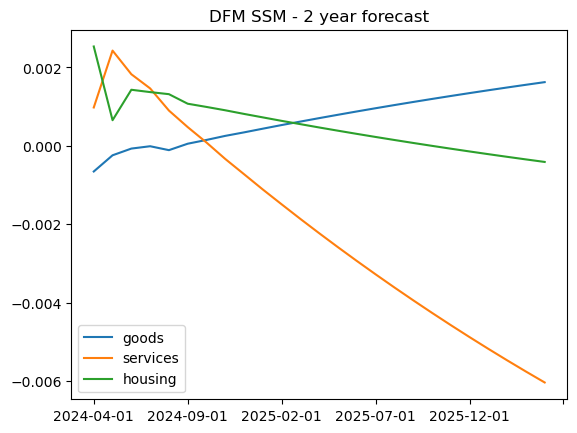

In [65]:
#==========================================================#
# NOTE: if estimation = True the code takes about 5 hours to run
estimation = False
#==========================================================#

factor_dict_ssm = factor_dict_monthly.copy()

# create global factor and regularize the other factors to be mean 0, std 1
global_factor = pd.DataFrame()
for factor in factor_dict_ssm:
    factor_norm             = (factor_dict_ssm[factor] - factor_dict_ssm[factor].mean())/factor_dict_ssm[factor].std()
    factor_dict_ssm[factor] = factor_norm
    global_factor           = pd.concat([global_factor, factor_norm], axis = 1)
factor_dict_ssm["global"]   = global_factor

Y_lags = 3

dfm_ssm = models.DFM_SSM(agg_sectors_inf, factor_dict_ssm, Y_lags)

if estimation:
    dfm_ssm._Get_Estimates()
    dfm_ssm._Create_Forecast().plot(title="DFM SSM - 2 year forecast")
    dfm_ssm._Check_Model_Performance(window_end="01-01-2019")

# if not estimating, load in pre-ran data
else:
    dfm_ssm.window_forecast = pd.read_csv("dfm_ssm_window_forecast.csv", index_col=0)
    dfm_ssm.window_errors   = pd.read_csv("dfm_ssm_window_errors.csv", index_col=0)
    dfm_ssm.factor_df       = pd.read_csv("dfm_ssm_states.csv", index_col=0)
    dfm_forecast            = pd.read_csv("dfm_ssm_current_forecast.csv", index_col=0)
    
    dfm_ssm.window_forecast.index = pd.to_datetime(dfm_ssm.window_forecast.index)
    dfm_ssm.window_errors.index   = pd.to_datetime(dfm_ssm.window_errors.index)
    dfm_ssm.factor_df.index       = pd.to_datetime(dfm_ssm.factor_df.index)

dfm_forecast.plot(title="DFM SSM - 2 year forecast")

The above estimates created from the factors below: 

<Axes: title={'center': 'DFM SSM - all states'}>

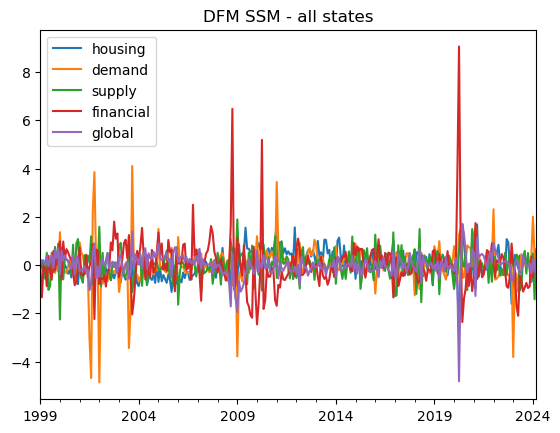

In [66]:
dfm_ssm.factor_df.plot(title="DFM SSM - all states")

It's interesting to look at the global factor -- made up of all the series. The trend drops leading up to the 2008 crisis, however, not nearly as much as during the Covid-19 pandemic. 

<Axes: title={'center': 'DFM SSM - global state'}>

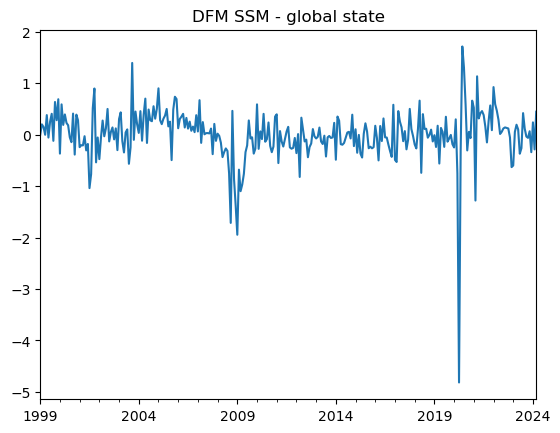

In [67]:
dfm_ssm.factor_df["global"].plot(title="DFM SSM - global state")

Notice that the forecasts and states of the DFM estimated through the Kalman filter look a bit off. The states seem much more volatile compared to their PCA and PPCA counterparts. This is most likely due to the larger amount of parameters, and as a result, restrictions of the state space estimation. 

For future extensions of this model I would like to apply a smoothing algorithm -- either the Kalman or the Durbin and Koopman smoother. In an effort to ameliorate the forecasts I think placing more rich restrictions on certain subsets of the parameters would be beneficial. Making sure that each set of states evolve according to $\rho$s that do not sum to more than one would keep the forecasts from exploding (i.e. $\rho_i + \rho_{global, i} < 1$).


## (5) Discussion

#### Method of Checking Model Performance:

A good way of checking how good the model is by referring to out of sample forecasts. All model classes (VAR, DFM_PCA, DFM_PPCA) have a _Check_Model_Performance() method which restimates the model every quarter (or month) and returns the quarterly (or monthly) forecast error over a specified window. The errors for the three main sectors are plotted below. Additionally, the forecasts are aggregated up to get the core PCE aggregate errors -- represented by "total error #" in the chart titles. Here are some results:

<Axes: title={'center': 'DFM SSM - pre-covid: total error 0.038636192200019834'}>

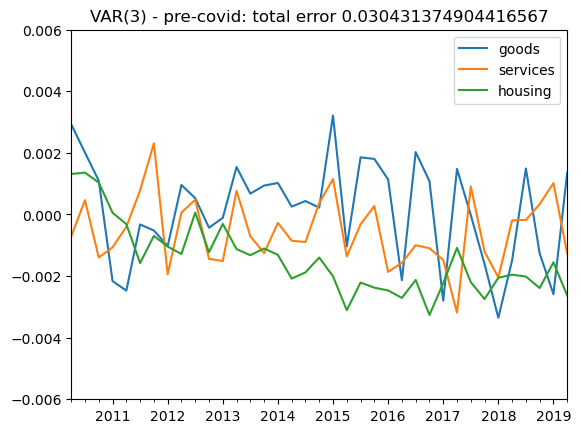

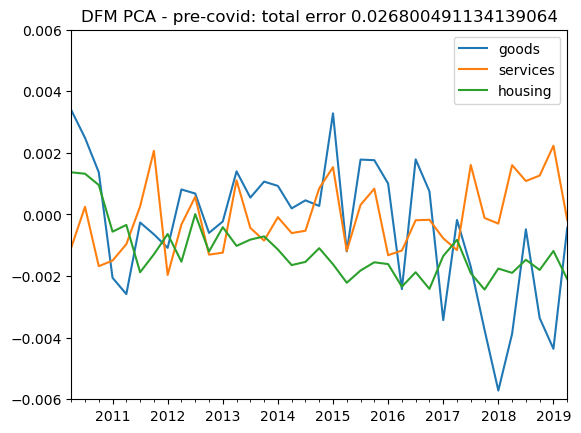

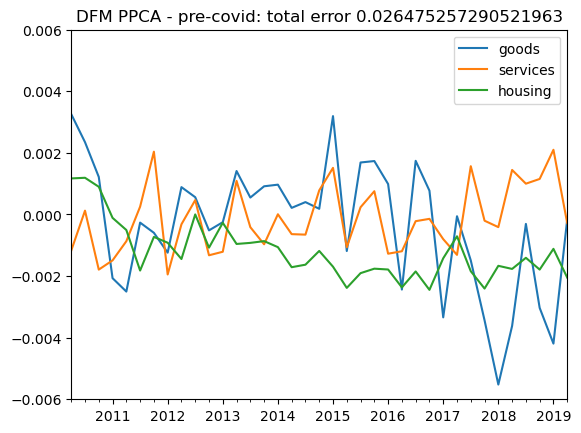

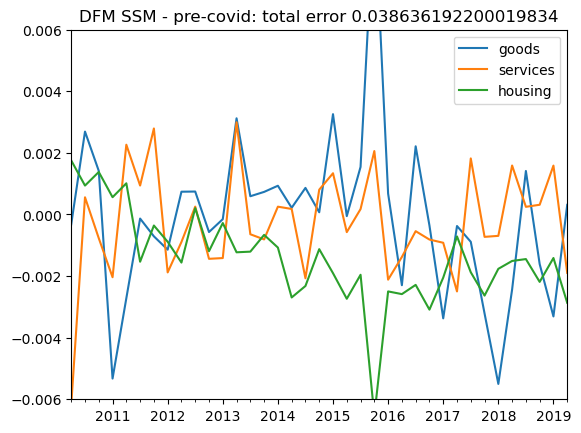

In [68]:
Y_lags = 3

var      = models.VAR(agg_sectors_inf, Y_lags)
dfm_pca  = models.DFM_PCA(agg_sectors_inf, factor_dict_monthly, Y_lags)
dfm_ppca = models.DFM_PPCA(agg_sectors_inf, factor_dict, Y_lags)

window_end = "01-01-2019"
var._Check_Model_Performance(window_end=window_end)
dfm_pca._Check_Model_Performance(window_end=window_end)
dfm_ppca._Check_Model_Performance(window_end=window_end)

var_core_pce_err      = (pd.DataFrame(dfm_helper_functions._Get_Agg_PCE_Window_Forecast(var.window_forecast, agg_shares)) - agg_pce_inf.loc[var.window_forecast.index].values).abs().sum()
dfm_pca_core_pce_err  = (pd.DataFrame(dfm_helper_functions._Get_Agg_PCE_Window_Forecast(dfm_pca.window_forecast, agg_shares)) - agg_pce_inf.loc[dfm_pca.window_forecast.index].values).abs().sum()
dfm_ppca_core_pce_err = (pd.DataFrame(dfm_helper_functions._Get_Agg_PCE_Window_Forecast(dfm_ppca.window_forecast, agg_shares)) - agg_pce_inf.loc[dfm_ppca.window_forecast.index].values).abs().sum()
dfm_ssm_core_pce_err  = (pd.DataFrame(dfm_helper_functions._Get_Agg_PCE_Window_Forecast(dfm_ssm.window_forecast, agg_shares)) - agg_pce_inf.loc[dfm_ppca.window_forecast.index].values).abs().sum()

var.window_errors.plot(title="VAR(3) - pre-covid: total error {}".format(var_core_pce_err[0]), ylim=(-0.006, 0.006,))
dfm_pca.window_errors.plot(title="DFM PCA - pre-covid: total error {}".format(dfm_pca_core_pce_err[0]), ylim=(-0.006, 0.006,))
dfm_ppca.window_errors.plot(title="DFM PPCA - pre-covid: total error {}".format(dfm_ppca_core_pce_err[0]), ylim=(-0.006, 0.006,))
dfm_ssm.window_errors.plot(title="DFM SSM - pre-covid: total error {}".format(dfm_ssm_core_pce_err[0]), ylim=(-0.006, 0.006,))

The DFMs do well in the pre-covid period, boasting lower total error than the VAR(3) baseline. The main motivation in this project was to see dynamic factor models' performance in turbulent times. The DFM estimated through the state space model does worse than the VAR(3) for the reasons outline above. Lets look at the errors up to the current date.

<Axes: title={'center': 'DFM PPCA - pre-covid: total error 0.0659420832978291'}>

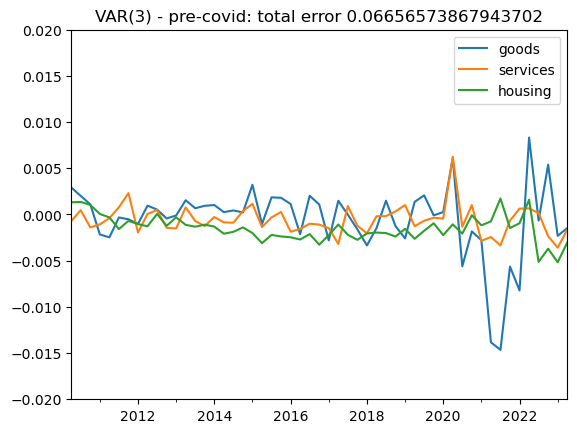

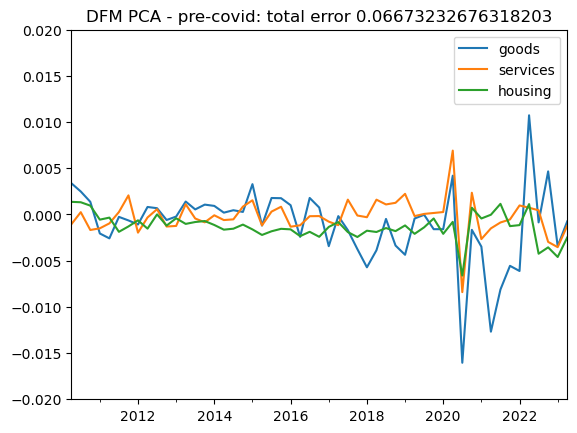

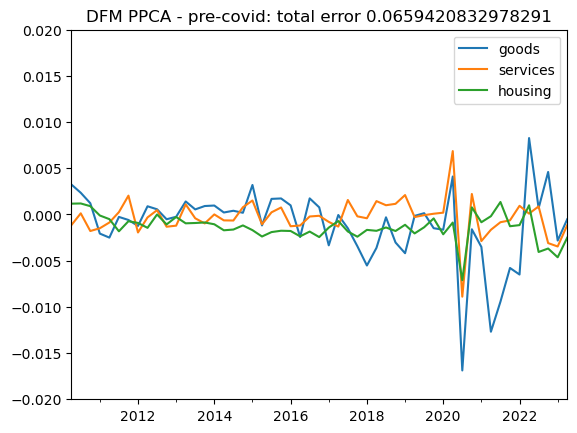

In [69]:
Y_lags = 3

var      = models.VAR(agg_sectors_inf, Y_lags)
dfm_pca  = models.DFM_PCA(agg_sectors_inf, factor_dict_monthly, Y_lags)
dfm_ppca = models.DFM_PPCA(agg_sectors_inf, factor_dict, Y_lags)

window_end = "01-01-2023"
var._Check_Model_Performance(window_end=window_end)
dfm_pca._Check_Model_Performance(window_end=window_end)
dfm_ppca._Check_Model_Performance(window_end=window_end)

var_core_pce_err      = (pd.DataFrame(dfm_helper_functions._Get_Agg_PCE_Window_Forecast(var.window_forecast, agg_shares)) - agg_pce_inf.loc[var.window_forecast.index].values).abs().sum()
dfm_pca_core_pce_err  = (pd.DataFrame(dfm_helper_functions._Get_Agg_PCE_Window_Forecast(dfm_pca.window_forecast, agg_shares)) - agg_pce_inf.loc[dfm_pca.window_forecast.index].values).abs().sum()
dfm_ppca_core_pce_err = (pd.DataFrame(dfm_helper_functions._Get_Agg_PCE_Window_Forecast(dfm_ppca.window_forecast, agg_shares)) - agg_pce_inf.loc[dfm_ppca.window_forecast.index].values).abs().sum()

var.window_errors.plot(title="VAR(3) - pre-covid: total error {}".format(var_core_pce_err[0]), ylim=(-0.02, 0.02,))
dfm_pca.window_errors.plot(title="DFM PCA - pre-covid: total error {}".format(dfm_pca_core_pce_err[0]), ylim=(-0.02, 0.02,))
dfm_ppca.window_errors.plot(title="DFM PPCA - pre-covid: total error {}".format(dfm_ppca_core_pce_err[0]), ylim=(-0.02, 0.02,))

Interestingly, only the DFM with factors estimated through PPCA performs better than the baseline VAR(3) -- granted not by much. Abstracting from the total errors, looking at the charts it seems that the DFMs initially perform worse when the pandemic hits and then better thereafter. One possible explaination is the factors are quite persitent and take time to adapt before they provide meaningful forecast value.

Note: the forecast errors for the DFM estimated through the SSM are not shown as they take quite a long time to estimate and my belief is that the model needs to be better calibrated before this exercise is worthwhile. 


## (6) References 

Barigozzi, Matteo . DYNAMIC FACTOR MODELS. 9 Apr. 2018, www.barigozzi.eu/MB_DF_lecture_notes.pdf.

Poncela, Pilar, et al. “Factor Extraction Using Kalman Filter and Smoothing: This Is Not Just Another Survey.” ScienceDirect, Sept. 2021,  https://doi.org/10.1016/j.ijforecast.2021.01.027.

Stock and  Watson. Dynamic Factor Models. 7 May 2010.

Stock and Watson. “Dynamic Factor Models, Factor-Augmented Vector Autoregressions, and Structural Vector Autoregressions in Macroeconomics.” Handbook of Macroeconomics, 1 Jan. 2016, pp. 415–525, https://doi.org/10.1016/bs.hesmac.2016.04.002.

Tipping, Michael, and Christopher Bishop. “Mixtures of Probabilistic Principal Component Analysers.” https://www.miketipping.com/papers.htm, 1999.

Verbeek, Jakob. Notes on Probabilistic PCA with Missing Values. 18 Mar. 2009, https://lear.inrialpes.fr/people/verbeek/.